# Summary

This file is a continuation of the previous 2 files. 



*   In the first file we setup the basic skeleton of the neural network
*   In the second file we reduced the number of parameters from ~6.4M to ~12.6K


Now, we want to address the overfitting aspect of the neural network and improve our test accuracy.


**Target**


1.   Address the Overfitting aspect of the neural network
2.   Reduce the number of parameters and get it to 8K-10K range
3.   Consistently hit the target test accuracy of 99.4%


**Result**

* Total Model Parameters :  11924
* Best Train Accuracy :  100.0
* Best Test Accuracy :  99.43
* Num of Epochs with test accuracy above 99.4% threshold: 3





**Analysis**

1.   First, we addressed the overfitting issue by adding Batch Normalisation and adding Dropout values
2.   The Test accuracy crossed the required threshold of 99.4% - thrice and that too before 15 epochs
3.   By editing the neural network, we hit our target of 99.4% multiple times but the number of parameters is above 10K
4. We also experimented with data augmentation by adding rotation to the train dataset


## Import Libraries

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [2]:
# We use this experimental data to identify the mean and std dev of the dataset

# simple transform
simple_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                      #  transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])
exp = datasets.MNIST('./data', train=True, download=True, transform=simple_transforms)
exp_data = exp.train_data
exp_data = exp.transform(exp_data.numpy())

print('[Train]')
print(' - Numpy Shape:', exp.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', exp.train_data.size())
print(' - min:', torch.min(exp_data))
print(' - max:', torch.max(exp_data))
print(' - mean:', torch.mean(exp_data))
print(' - std:', torch.std(exp_data))
print(' - var:', torch.var(exp_data))

/usr/local/lib/python3.8/dist-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(0.)
 - max: tensor(1.)
 - mean: tensor(0.1307)
 - std: tensor(0.3081)
 - var: tensor(0.0949)


## Data Import & transformation

In [3]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

In [4]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? False


In [5]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
train_data = train.train_data
train_data = train.transform(train_data.numpy())


print('[Train]')
print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train.train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = next(dataiter)

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')


TypeError: ignored

NameError: ignored

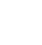

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt


figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

## Model

Defining the model & Initialising it

In [ ]:
# We change the way we define the neural network. Earlier we used to work one convolution layer at a time, now we'll add more operations on top of the convolution layer
# All of this will fall under 1 block.
dropout_value = 0.15
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=4, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(4),
            nn.ReLU()
        ) # Input - 28 x 28 x 1 | Output - 26 x 26 x 4 | RF - 3 | Kernel - 3 x 3 x 1 x 4

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=4, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(8),
            nn.ReLU()
        ) # Input - 26 x 26 x 4 | Output - 24 x 24 x 8 | RF - 5 | Kernel - 3 x 3 x 4 x 8
        
        # TRANSITION BLOCK 1
        
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 24
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 11
        # Input - 24 x 24 x 8 | Output - 12 x 12 x 8 | RF - 10 | Kernel - 2 x 2

        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Dropout(dropout_value)
        ) # Input - 12 x 12 x 8 | Output - 10 x 10 x 16 | RF - 12 | Kernel - 3 x 3 x 8 x 16
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=16, kernel_size=(1, 1), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Dropout(dropout_value)
          # If we increase the number of channels to 32, it increases the number of parameters by 4.6K, hence maintaining the channels at 16 
          # What is the benefit of having this block then? 
        ) # Input - 10 x 10 x 16 | Output - 10 x 10 x 16 | RF - 12 | Kernel - 3 x 3 x 16 x 16

        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Dropout(dropout_value)
          # If we increase the number of channels to 32, it increases the number of parameters by 4.6K, hence maintaining the channels at 16 
          # What is the benefit of having this block then? 
        ) # Input - 8 x 8 x 16 | Output - 8 x 8 x 16 | RF - 14 | Kernel - 3 x 3 x 16 x 16

        # OUTPUT BLOCK
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU()
        ) # Input - 8 x 8 x 16 | Output - 6 x 6 x 16 | RF - 16 | Kernel - 3 x 3 x 16 x 16
        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU()
        ) # Input - 6 x 6 x 16 | Output - 6 x 6 x 10 | RF - 18 | Kernel - 3 x 3 x 16 x 10
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=4)
        ) # output_size = 1
        # ) # Input - 6 x 6 x 10 | Output - 1 x 1 x 10 | RF - 21 | Kernel - 6 x 6 x 10 x 10
        self.convblock9 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            # nn.BatchNorm2d(10),
            # nn.ReLU(),
            # nn.Dropout(dropout_value)
        ) # ) # Input - 1 x 1 x 10 | Output - 1 x 1 x 10 | RF - 21 | Kernel - 1 x 1 x 10 x 10
        self.dropout = nn.Dropout(dropout_value)

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.convblock8(x)
        x = self.gap(x)
        x = self.convblock9(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

## Model Parameters

In [18]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
cpu
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 4, 26, 26]              36
       BatchNorm2d-2            [-1, 4, 26, 26]               8
              ReLU-3            [-1, 4, 26, 26]               0
            Conv2d-4            [-1, 8, 24, 24]             288
       BatchNorm2d-5            [-1, 8, 24, 24]              16
              ReLU-6            [-1, 8, 24, 24]               0
            Conv2d-7           [-1, 16, 24, 24]             128
         MaxPool2d-8           [-1, 16, 12, 12]               0
            Conv2d-9           [-1, 32, 10, 10]           4,608
      BatchNorm2d-10           [-1, 32, 10, 10]              64
             ReLU-11           [-1, 32, 10, 10]               0
          Dropout-12           [-1, 32, 10, 10]               0


## Training & Testing the Neural Network

Run the model and check 

In [ ]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

## Testing our model

In [10]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

EPOCH: 0


Loss=0.07375553995370865 Batch_id=937 Accuracy=88.48: 100%|██████████| 938/938 [01:10<00:00, 13.37it/s]



Test set: Average loss: 0.0535, Accuracy: 9844/10000 (98.44%)

EPOCH: 1


Loss=0.027978593483567238 Batch_id=937 Accuracy=97.56: 100%|██████████| 938/938 [01:01<00:00, 15.29it/s]



Test set: Average loss: 0.0409, Accuracy: 9889/10000 (98.89%)

EPOCH: 2


Loss=0.0711149349808693 Batch_id=937 Accuracy=98.00: 100%|██████████| 938/938 [00:59<00:00, 15.85it/s]



Test set: Average loss: 0.0292, Accuracy: 9902/10000 (99.02%)

EPOCH: 3


Loss=0.04494500532746315 Batch_id=937 Accuracy=98.28: 100%|██████████| 938/938 [01:00<00:00, 15.48it/s]



Test set: Average loss: 0.0272, Accuracy: 9920/10000 (99.20%)

EPOCH: 4


Loss=0.03568989038467407 Batch_id=937 Accuracy=98.41: 100%|██████████| 938/938 [00:58<00:00, 15.96it/s]



Test set: Average loss: 0.0243, Accuracy: 9916/10000 (99.16%)

EPOCH: 5


Loss=0.06658781319856644 Batch_id=937 Accuracy=98.53: 100%|██████████| 938/938 [00:59<00:00, 15.73it/s]



Test set: Average loss: 0.0240, Accuracy: 9925/10000 (99.25%)

EPOCH: 6


Loss=0.36980631947517395 Batch_id=937 Accuracy=98.56: 100%|██████████| 938/938 [00:59<00:00, 15.72it/s]



Test set: Average loss: 0.0228, Accuracy: 9917/10000 (99.17%)

EPOCH: 7


Loss=0.07622472941875458 Batch_id=937 Accuracy=98.64: 100%|██████████| 938/938 [00:58<00:00, 15.90it/s]



Test set: Average loss: 0.0241, Accuracy: 9929/10000 (99.29%)

EPOCH: 8


Loss=0.12336332350969315 Batch_id=937 Accuracy=98.65: 100%|██████████| 938/938 [00:59<00:00, 15.84it/s]



Test set: Average loss: 0.0224, Accuracy: 9919/10000 (99.19%)

EPOCH: 9


Loss=0.34600645303726196 Batch_id=937 Accuracy=98.72: 100%|██████████| 938/938 [01:00<00:00, 15.58it/s]



Test set: Average loss: 0.0212, Accuracy: 9935/10000 (99.35%)

EPOCH: 10


Loss=0.0028733662329614162 Batch_id=937 Accuracy=98.79: 100%|██████████| 938/938 [00:58<00:00, 16.13it/s]



Test set: Average loss: 0.0190, Accuracy: 9936/10000 (99.36%)

EPOCH: 11


Loss=0.019304955378174782 Batch_id=937 Accuracy=98.81: 100%|██████████| 938/938 [00:59<00:00, 15.73it/s]



Test set: Average loss: 0.0217, Accuracy: 9928/10000 (99.28%)

EPOCH: 12


Loss=0.01410830207169056 Batch_id=937 Accuracy=98.86: 100%|██████████| 938/938 [00:58<00:00, 15.91it/s]



Test set: Average loss: 0.0184, Accuracy: 9943/10000 (99.43%)

EPOCH: 13


Loss=0.08048190176486969 Batch_id=937 Accuracy=98.90: 100%|██████████| 938/938 [00:58<00:00, 15.94it/s]



Test set: Average loss: 0.0174, Accuracy: 9941/10000 (99.41%)

EPOCH: 14


Loss=0.018597794696688652 Batch_id=937 Accuracy=98.93: 100%|██████████| 938/938 [00:59<00:00, 15.63it/s]



Test set: Average loss: 0.0178, Accuracy: 9938/10000 (99.38%)

EPOCH: 15


Loss=0.12172360718250275 Batch_id=937 Accuracy=98.97: 100%|██████████| 938/938 [00:59<00:00, 15.75it/s]



Test set: Average loss: 0.0171, Accuracy: 9941/10000 (99.41%)

EPOCH: 16


Loss=0.019666878506541252 Batch_id=937 Accuracy=98.97: 100%|██████████| 938/938 [00:59<00:00, 15.66it/s]



Test set: Average loss: 0.0205, Accuracy: 9937/10000 (99.37%)

EPOCH: 17


Loss=0.02079240418970585 Batch_id=937 Accuracy=98.99: 100%|██████████| 938/938 [01:00<00:00, 15.44it/s]



Test set: Average loss: 0.0203, Accuracy: 9934/10000 (99.34%)

EPOCH: 18


Loss=0.045451074838638306 Batch_id=937 Accuracy=99.03: 100%|██████████| 938/938 [01:00<00:00, 15.49it/s]



Test set: Average loss: 0.0209, Accuracy: 9931/10000 (99.31%)

EPOCH: 19


Loss=0.1815895140171051 Batch_id=937 Accuracy=99.05: 100%|██████████| 938/938 [01:01<00:00, 15.34it/s]



Test set: Average loss: 0.0185, Accuracy: 9938/10000 (99.38%)



In [11]:
import numpy as np
t = [t.cpu().item() for t in train_losses]

Text(0.5, 1.0, 'Test Accuracy')

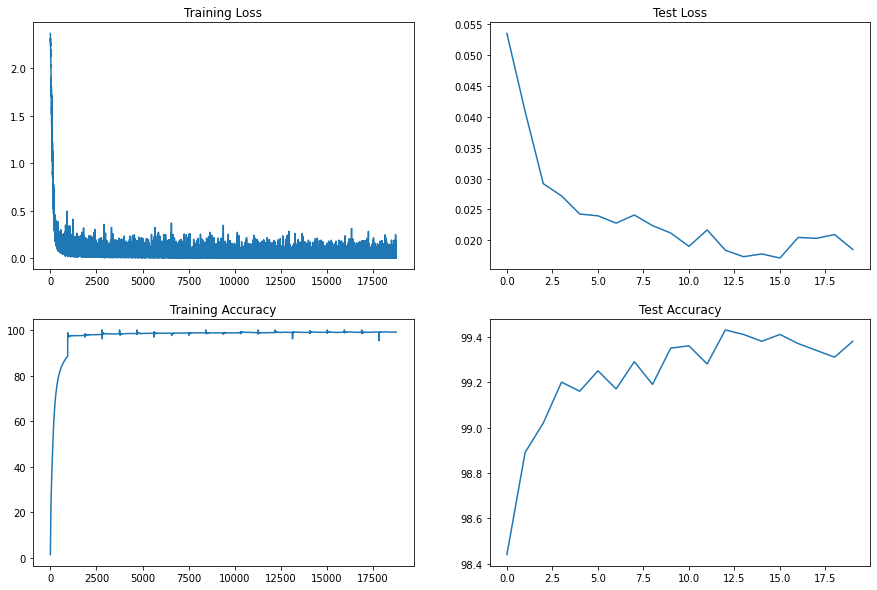

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(t)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

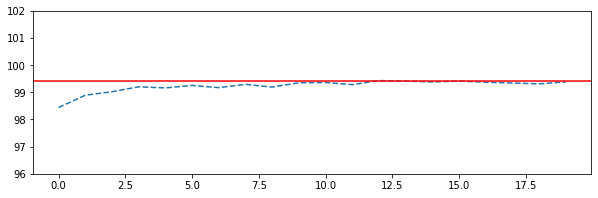

In [13]:
ymin = 96
ymax = 102
plt.figure(figsize=(10, 3))
#plt.plot(train_acc, label = 'train_acc', linestyle = "--")
plt.plot(test_acc, label = 'test_acc', linestyle = "--")
plt.axhline(y=99.4, color='r', linestyle='-')
plt.ylim(ymin, ymax)
plt.show()

In [14]:
print('Total Model Parameters : ', sum(p.numel() for p in model.parameters()))
print('Best Train Accuracy : ', max(train_acc))
print('Best Test Accuracy : ', max(test_acc))
x = [x for x in test_acc if x >= 99.4]
print('# of Epochs with test accuracy above 99.4% threshold:', len(x))

Total Model Parameters :  11924
Best Train Accuracy :  100.0
Best Test Accuracy :  99.43
# of Epochs with test accuracy above 99.4% threshold: 3


In [15]:
max(train_acc)

100.0

In [16]:
test_acc

[98.44,
 98.89,
 99.02,
 99.2,
 99.16,
 99.25,
 99.17,
 99.29,
 99.19,
 99.35,
 99.36,
 99.28,
 99.43,
 99.41,
 99.38,
 99.41,
 99.37,
 99.34,
 99.31,
 99.38]

# We change the way we define the neural network. Earlier we used to work one convolution layer at a time, now we'll add more operations on top of the convolution layer
# All of this will fall under 1 block.
dropout_value = 0.15
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=4, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(4),
            nn.ReLU()
        ) # Input - 28 x 28 x 1 | Output - 26 x 26 x 4 | RF - 3 | Kernel - 3 x 3 x 1 x 4

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=4, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(8),
            nn.ReLU()
        ) # Input - 26 x 26 x 4 | Output - 24 x 24 x 8 | RF - 5 | Kernel - 3 x 3 x 4 x 8
        
        # TRANSITION BLOCK 1
        
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 24
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 11
        # Input - 24 x 24 x 8 | Output - 12 x 12 x 8 | RF - 10 | Kernel - 2 x 2

        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Dropout(dropout_value)
        ) # Input - 12 x 12 x 8 | Output - 10 x 10 x 16 | RF - 12 | Kernel - 3 x 3 x 8 x 16
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=16, kernel_size=(1, 1), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Dropout(dropout_value)
          # If we increase the number of channels to 32, it increases the number of parameters by 4.6K, hence maintaining the channels at 16 
          # What is the benefit of having this block then? 
        ) # Input - 10 x 10 x 16 | Output - 10 x 10 x 16 | RF - 12 | Kernel - 3 x 3 x 16 x 16

        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Dropout(dropout_value)
          # If we increase the number of channels to 32, it increases the number of parameters by 4.6K, hence maintaining the channels at 16 
          # What is the benefit of having this block then? 
        ) # Input - 8 x 8 x 16 | Output - 8 x 8 x 16 | RF - 14 | Kernel - 3 x 3 x 16 x 16

        # OUTPUT BLOCK
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU()
        ) # Input - 8 x 8 x 16 | Output - 6 x 6 x 16 | RF - 16 | Kernel - 3 x 3 x 16 x 16
        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU()
        ) # Input - 6 x 6 x 16 | Output - 6 x 6 x 10 | RF - 18 | Kernel - 3 x 3 x 16 x 10
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=4)
        ) # output_size = 1
        # ) # Input - 6 x 6 x 10 | Output - 1 x 1 x 10 | RF - 21 | Kernel - 6 x 6 x 10 x 10
        self.convblock9 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            # nn.BatchNorm2d(10),
            # nn.ReLU(),
            # nn.Dropout(dropout_value)
        ) # ) # Input - 1 x 1 x 10 | Output - 1 x 1 x 10 | RF - 21 | Kernel - 1 x 1 x 10 x 10
        self.dropout = nn.Dropout(dropout_value)

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.convblock8(x)
        x = self.gap(x)
        x = self.convblock9(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

EPOCH: 0
Loss=0.1817273050546646 Batch_id=937 Accuracy=89.99: 100%|██████████| 938/938 [01:04<00:00, 14.58it/s]

Test set: Average loss: 0.0469, Accuracy: 9860/10000 (98.60%)

EPOCH: 1
Loss=0.024927718564867973 Batch_id=937 Accuracy=97.95: 100%|██████████| 938/938 [00:54<00:00, 17.25it/s]

Test set: Average loss: 0.0369, Accuracy: 9891/10000 (98.91%)

EPOCH: 2
Loss=0.02568667009472847 Batch_id=937 Accuracy=98.33: 100%|██████████| 938/938 [00:53<00:00, 17.45it/s]

Test set: Average loss: 0.0292, Accuracy: 9908/10000 (99.08%)

EPOCH: 3
Loss=0.020776044577360153 Batch_id=937 Accuracy=98.57: 100%|██████████| 938/938 [00:54<00:00, 17.30it/s]

Test set: Average loss: 0.0294, Accuracy: 9910/10000 (99.10%)

EPOCH: 4
Loss=0.0651998221874237 Batch_id=937 Accuracy=98.73: 100%|██████████| 938/938 [00:55<00:00, 16.78it/s]

Test set: Average loss: 0.0252, Accuracy: 9915/10000 (99.15%)

EPOCH: 5
Loss=0.019690189510583878 Batch_id=937 Accuracy=98.77: 100%|██████████| 938/938 [00:56<00:00, 16.68it/s]

Test set: Average loss: 0.0226, Accuracy: 9931/10000 (99.31%)

EPOCH: 6
Loss=0.006541811861097813 Batch_id=937 Accuracy=98.87: 100%|██████████| 938/938 [00:55<00:00, 16.85it/s]

Test set: Average loss: 0.0213, Accuracy: 9933/10000 (99.33%)

EPOCH: 7
Loss=0.046682123094797134 Batch_id=937 Accuracy=98.88: 100%|██████████| 938/938 [00:55<00:00, 16.81it/s]

Test set: Average loss: 0.0222, Accuracy: 9930/10000 (99.30%)

EPOCH: 8
Loss=0.0017001306405290961 Batch_id=937 Accuracy=99.00: 100%|██████████| 938/938 [00:57<00:00, 16.32it/s]

Test set: Average loss: 0.0196, Accuracy: 9936/10000 (99.36%)

EPOCH: 9
Loss=0.11725009977817535 Batch_id=937 Accuracy=98.99: 100%|██████████| 938/938 [00:55<00:00, 16.99it/s]

Test set: Average loss: 0.0187, Accuracy: 9945/10000 (99.45%)

EPOCH: 10
Loss=0.0038126646541059017 Batch_id=937 Accuracy=99.00: 100%|██████████| 938/938 [00:55<00:00, 16.90it/s]

Test set: Average loss: 0.0190, Accuracy: 9940/10000 (99.40%)

EPOCH: 11
Loss=0.0653543472290039 Batch_id=937 Accuracy=99.05: 100%|██████████| 938/938 [00:56<00:00, 16.59it/s]

Test set: Average loss: 0.0236, Accuracy: 9925/10000 (99.25%)

EPOCH: 12
Loss=0.13482144474983215 Batch_id=937 Accuracy=99.10: 100%|██████████| 938/938 [00:55<00:00, 17.02it/s]

Test set: Average loss: 0.0189, Accuracy: 9943/10000 (99.43%)

EPOCH: 13
Loss=0.012560486793518066 Batch_id=937 Accuracy=99.11: 100%|██████████| 938/938 [00:55<00:00, 16.77it/s]

Test set: Average loss: 0.0234, Accuracy: 9935/10000 (99.35%)

EPOCH: 14
Loss=0.014288542792201042 Batch_id=937 Accuracy=99.13: 100%|██████████| 938/938 [00:56<00:00, 16.52it/s]

Test set: Average loss: 0.0202, Accuracy: 9935/10000 (99.35%)

EPOCH: 15
Loss=0.02761080674827099 Batch_id=937 Accuracy=99.14: 100%|██████████| 938/938 [00:56<00:00, 16.55it/s]

Test set: Average loss: 0.0208, Accuracy: 9936/10000 (99.36%)

EPOCH: 16
Loss=0.00967184267938137 Batch_id=937 Accuracy=99.21: 100%|██████████| 938/938 [00:55<00:00, 16.99it/s]

Test set: Average loss: 0.0216, Accuracy: 9929/10000 (99.29%)

EPOCH: 17
Loss=0.13152864575386047 Batch_id=937 Accuracy=99.14: 100%|██████████| 938/938 [00:55<00:00, 16.81it/s]

Test set: Average loss: 0.0200, Accuracy: 9930/10000 (99.30%)

EPOCH: 18
Loss=0.014984813518822193 Batch_id=937 Accuracy=99.25: 100%|██████████| 938/938 [00:58<00:00, 15.97it/s]

Test set: Average loss: 0.0178, Accuracy: 9950/10000 (99.50%)

EPOCH: 19
Loss=0.0495365709066391 Batch_id=937 Accuracy=99.24: 100%|██████████| 938/938 [00:56<00:00, 16.57it/s]

Test set: Average loss: 0.0230, Accuracy: 9926/10000 (99.26%)

In [ ]:
1+2